In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading the zip file
import os
import zipfile

path = '/content/drive/MyDrive/dataset_audio.zip'
with zipfile.ZipFile(path, 'r') as zip:
  zip.extractall()

In [4]:
#number of audio files in the dataset
dataset_path = '/content/test'
len(os.listdir(dataset_path))

11440

In [5]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [6]:
os.listdir(dataset_path)[:5]

['0_02acaa.wav',
 '4_8c7ca9.json',
 '2_0bbf75.wav',
 '1_074d2d.json',
 '10_ab7ff5.wav']

/content/test/0_005682.wav
audio:  [ 0.00690653  0.0069574   0.00490919 ... -0.0022109  -0.00225747
 -0.00144003] 

sample_rate:  22050


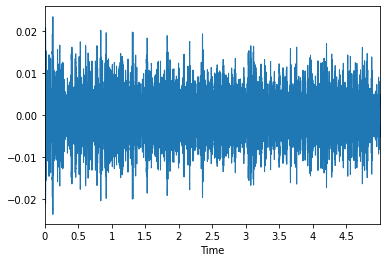

In [76]:
#reading a audio file
file = os.path.join(dataset_path, '0_005682.wav')
print(file)
audio, sample_rate = librosa.load(file)
print("audio: ", audio, '\n')
print("sample_rate: ", sample_rate)

librosa.display.waveplot(audio)

In [8]:
#converting audio to features that can be used in the models
import json

X_train = []
Y_train = []
X_train2 = []
for file in os.listdir(dataset_path):
  #checking if file is json or wave
  temp = file.split('.')
  if temp[1]  == 'json':
    continue
  #reading audio
  audio, sample_rate = librosa.load(os.path.join(dataset_path, file))
  #extracting features
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
  X_train2.append(mfccs_features)
  scaled_features = np.mean(mfccs_features.T, axis=0)
  #appending compressed 1D features to Xtrain
  X_train.append(scaled_features)
  #extracting labels
  file_json = temp[0] + '.json'
  file_json = open(os.path.join(dataset_path, file_json), )
  labels = json.load(file_json)
  #counting number of males and females in a audio
  Male = 0
  Female = 0
  for i in range(len(labels)):
    if labels[i]['sex'] == 'F':
      Female += 1
    else:
      Male += 1
  Y_train.append((Male, Female))

In [70]:
#adding my own data and uploading files thorugh the device
from google.colab import  files
for i in range(3):
  files.upload()

Saving audio1.wav to audio1.wav


Saving audio2.wav to audio2.wav


Saving audio3.wav to audio3.wav


In [72]:
#adding my own data to the training data and labels

def extract_features(file):
  audio, sample_rate = librosa.load(file)
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
  scaled_features = np.mean(mfccs_features.T, axis=0)
  return scaled_features

features1 = extract_features('audio1.wav')
X_train = list(X_train)
Y_train = list(Y_train)
X_train.append(features1)
Y_train.append((1, 0))


features2 = extract_features('audio2.wav')
X_train.append(features2)
Y_train.append((1, 1))


features3 = extract_features('audio3.wav')
X_train.append(features3)
Y_train.append((0, 0))


In [73]:
#saving training features and labels
data = np.array(X_train)
np.savez("x_train", data)

data = np.array(X_train2)
np.savez("x_train2", data)

data = np.array(Y_train)
np.savez("y_train", data)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers

In [10]:
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)
X_train = tf.keras.utils.normalize(X_train, axis=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               26112     
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

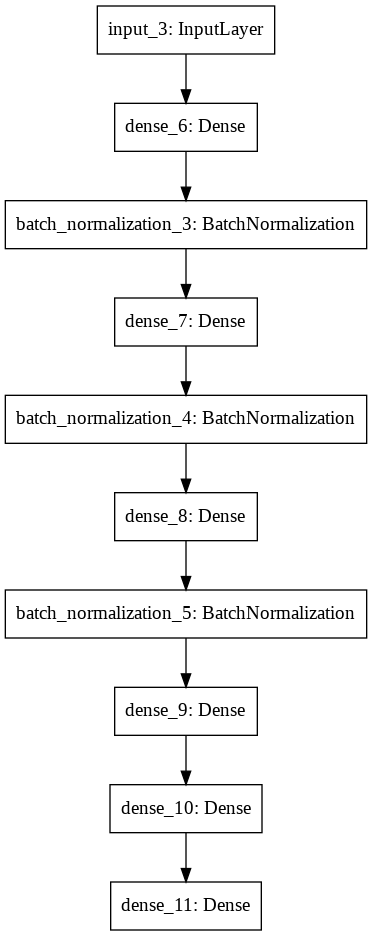

In [5]:
#model architecture
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(50)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))


model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, to_file='model.png')

In [52]:
X_train[0].shape
from sklearn.model_selection import train_test_split
X_train = np.array(X_train)
Y_train = np.array(Y_train)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [13]:
x_train.shape, y_train.shape

((5148, 50), (5148, 2))

In [14]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

In [57]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                      restore_best_weights=True, patience=10)
history = model.fit(x=x_train, y=y_train, validation_split=0.1, 
                    epochs=30, batch_size=16, callbacks=[earlystopping])

Epoch 1/30
290/290 [==============================] - 3s 7ms/step - loss: 0.7921 - accuracy: 0.7641 - val_loss: 1.3592 - val_accuracy: 0.4932
Epoch 2/30
290/290 [==============================] - 2s 7ms/step - loss: 0.6911 - accuracy: 0.7833 - val_loss: 0.7964 - val_accuracy: 0.6874
Epoch 3/30
290/290 [==============================] - 2s 7ms/step - loss: 0.6428 - accuracy: 0.7867 - val_loss: 0.6683 - val_accuracy: 0.7767
Epoch 4/30
290/290 [==============================] - 2s 7ms/step - loss: 0.6310 - accuracy: 0.7949 - val_loss: 0.6639 - val_accuracy: 0.7748
Epoch 5/30
290/290 [==============================] - 2s 6ms/step - loss: 0.6193 - accuracy: 0.7978 - val_loss: 0.5508 - val_accuracy: 0.8117
Epoch 6/30
290/290 [==============================] - 2s 6ms/step - loss: 0.5962 - accuracy: 0.8023 - val_loss: 0.5443 - val_accuracy: 0.7243
Epoch 7/30
290/290 [==============================] - 2s 6ms/step - loss: 0.6063 - accuracy: 0.7984 - val_loss: 0.5789 - val_accuracy: 0.8466
Epoch 

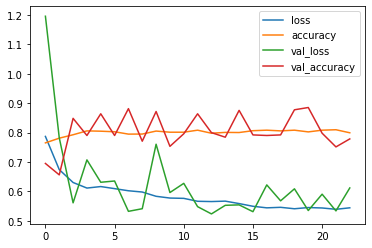

In [29]:
df = pd.DataFrame(history.history)
df.plot()
plt.legend()


In [30]:
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [18]:
model.evaluate(x_test, y_test)
#getting 86% accuracy on test data

18/18 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.8636


[0.4636082053184509, 0.8636363744735718]

In [77]:
from google.colab import files
files.upload()

Saving my_audio.wav to my_audio (1).wav


{'my_audio.wav': b'RIFF$\x80\x06\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x00\x10\x00data\x00\x80\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [78]:
#experimenting with my own data
def audio_to_features(file):
  audio, sample_rate = librosa.load(file)
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
  scaled_features = np.mean(mfccs_features.T, axis=0)
  x = tf.convert_to_tensor(scaled_features)
  x = tf.keras.utils.normalize(x, axis=0)
  return x

model.predict(audio_to_features('/content/my_audio.wav'))

array([[ 1.2345703 , -0.21577649]], dtype=float32)

In [ ]:
** CNN based architecture using spectrogram of a wav file **


## CNN based architecture using spectrogram of a wav file


[[3.0189338e-01 7.7097076e+01 5.1748596e+02 ... 5.9669566e-01
  6.5581805e+02 1.0336247e+02]
 [1.2162266e+01 2.0158403e+03 5.0652593e+03 ... 3.5095657e+01
  7.1154575e+03 5.5579658e+03]
 [8.5111675e+00 1.0261729e+03 1.2621627e+04 ... 1.2416834e+01
  1.1219712e+03 8.9835602e+04]
 ...
 [8.1000384e-04 3.6474823e-03 5.4516982e-02 ... 1.7980725e-03
  5.5031054e-02 1.9282899e-03]
 [1.4666152e-03 1.4197569e-02 6.7183606e-02 ... 2.5613098e-03
  2.2570454e-02 1.7174358e-02]
 [3.7671922e-04 8.2843925e-04 1.8043926e-02 ... 4.9514732e-05
  5.5989651e-03 5.7570741e-04]]


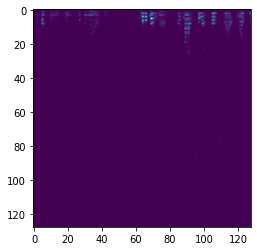

In [118]:
from scipy import signal
from scipy.io import wavfile
from PIL import Image as im
import cv2

def wav_to_spectrogram(file):
  sample_rate, samples = wavfile.read(file)
  frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
  spectrogram = cv2.resize(spectrogram, dsize=(128, 128))
  # norm_img = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
  return spectrogram
  
x = wav_to_spectrogram(os.path.join(dataset_path, '1_42d601.wav'))
print(x)

plt.imshow(x)


In [126]:
X_img = []
Y_img = []

for file in os.listdir(dataset_path):
  #checking if file is json or wave
  temp = file.split('.')
  if temp[1]  == 'json':
    continue
  
  img = wav_to_spectrogram(os.path.join(dataset_path, file))
  X_img.append(img)
  #extracting labels
  file_json = temp[0] + '.json'
  file_json = open(os.path.join(dataset_path, file_json), )
  labels = json.load(file_json)
  #counting number of males and females in a audio
  Male = 0
  Female = 0
  for i in range(len(labels)):
    if labels[i]['sex'] == 'F':
      Female += 1
    else:
      Male += 1
  Y_img.append((Male, Female))

Text(0.5, 1.0, 'Males: 0 Females: 0')

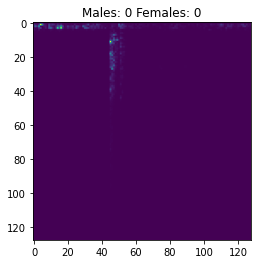

In [127]:
plt.imshow(X_img[0])
plt.title(f'Males: {Y_img[0][0]} Females: {Y_img[0][1]}')

In [125]:
X_img.shape

TensorShape([5720, 128, 128, 1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)           

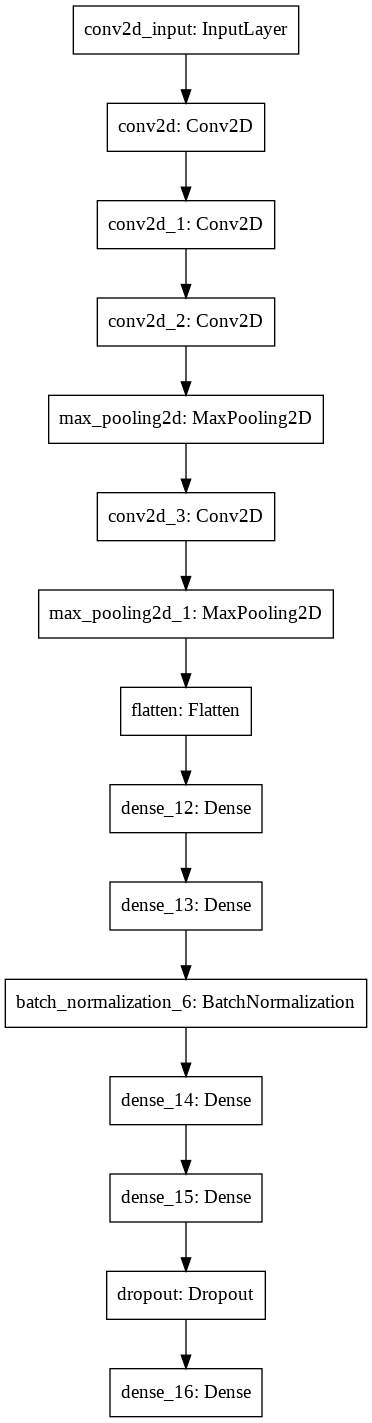

In [6]:
#CNN model
Model = tf.keras.Sequential()

Model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(128, 128, 1), activation='relu'))
Model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
Model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
Model.add(layers.MaxPooling2D(pool_size=(2, 2)))


Model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
Model.add(layers.MaxPooling2D(pool_size=(2, 2)))



Model.add(layers.Flatten())
Model.add(layers.Dense(512, activation='relu'))
Model.add(layers.Dense(128, activation='relu'))
Model.add(layers.BatchNormalization())

Model.add(layers.Dense(64, activation='relu'))
Model.add(layers.Dense(32, activation='relu'))
Model.add(layers.Dropout(0.1))
Model.add(layers.Dense(2, activation='relu'))

Model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
Model.summary()
tf.keras.utils.plot_model(Model, to_file='Model.png')

In [133]:
#splitting training and test
x_train, x_test, y_train, y_test = train_test_split(np.array(X_img), np.array(Y_img), test_size=0.10)

x_train = tf.convert_to_tensor(x_train)
x_train = tf.reshape(x_train, shape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

x_test = tf.convert_to_tensor(x_test)
x_test = tf.reshape(x_test, shape=(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

y_train = tf.convert_to_tensor(y_train)

y_test = tf.convert_to_tensor(y_test)


In [ ]:
history = Model.fit(x=x_train, y=y_train, validation_split=0.05,
                    epochs=20, batch_size=16, callbacks=[earlystopping])


Epoch 1/20
306/306 [==============================] - 55s 178ms/step - loss: 1.0462 - accuracy: 0.6579 - val_loss: 2.0349 - val_accuracy: 0.7868
Epoch 2/20
306/306 [==============================] - 53s 172ms/step - loss: 0.8394 - accuracy: 0.7538 - val_loss: 0.7901 - val_accuracy: 0.6783
Epoch 3/20
306/306 [==============================] - 52s 171ms/step - loss: 0.7662 - accuracy: 0.7875 - val_loss: 1.3181 - val_accuracy: 0.8178
Epoch 4/20
306/306 [==============================] - 52s 171ms/step - loss: 0.7391 - accuracy: 0.7939 - val_loss: 0.8693 - val_accuracy: 0.8101
Epoch 5/20
306/306 [==============================] - 52s 171ms/step - loss: 0.6942 - accuracy: 0.8135 - val_loss: 0.6531 - val_accuracy: 0.8527
Epoch 6/20
306/306 [==============================] - 52s 170ms/step - loss: 0.6645 - accuracy: 0.8176 - val_loss: 0.8590 - val_accuracy: 0.8450
Epoch 7/20
  6/306 [..............................] - ETA: 50s - loss: 0.6019 - accuracy: 0.8229

In [1]:
Model.evaluate(x_test, y_test)

**Methods to improve accuracy**


*  Try out different loss functions, optimizers,  learning rates and activation function

*  Experiment with different types of network architectures, dense layers and number of neurons

* We can use keras tuner to try out different combinations which can increase validation accuracy

* We can also use also data augmentation  to increase the size of dataset by adding some random noise

**Test accuracy** 

1.   Male count accuracy : 0.87
2.   Female count accuracy : 0.85


